In [2]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import matplotlib as mpl
from vireoSNP import BinomMixtureVB
import seaborn as sns

from mquad.mquad_utils import plot_confusionMatrix, confusionMatrix
from vireoSNP.plot.base_plot import heat_matrix
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


## Explore the BAF of the 2 clones using xclones

In [3]:
import scanpy as sc
import pickle
import anndata as adata

In [4]:
BAF_bin_phased_adata = adata.read_h5ad('data/BAF_bin_phased_adata.hdf5')
file = open('data/mapping_dic2.pkl', "rb")
mapping_dic2 = pickle.load(file)
file.close()

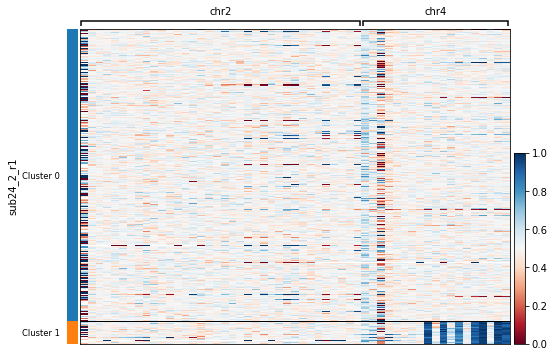

In [5]:
#sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
ax = sc.pl.heatmap(BAF_bin_phased_adata, mapping_dic2, groupby='sub24_2_r1',cmap="RdBu", show=True, save="Fig_4a.svg")

## Fit vireo model on input data (Fig. 4b)
As always, we first import the AD and DP counts of informative mtDNA variants found by MQuad, then identify clones with vireoSNP. The model fitting step will take a while (~2-5min) since the dataset has a lot of cells. Sometimes it doesn't converge (Warning: VB did not converge), but it is fine because we are using a large number of random initializations.

In [6]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((24, 5220), (24, 5220))

In [7]:
#fit on mquad output
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=5)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

In [8]:
## how many cells are assignable?

a = np.sum(np.max(mquad_modelCA.ID_prob, axis=1) > 0.8)/5220

print("Percentage of assignable cells: ", a)

Percentage of assignable cells:  0.9344827586206896


Precision = 0.522354005625381
Recall = 0.9479421070893247


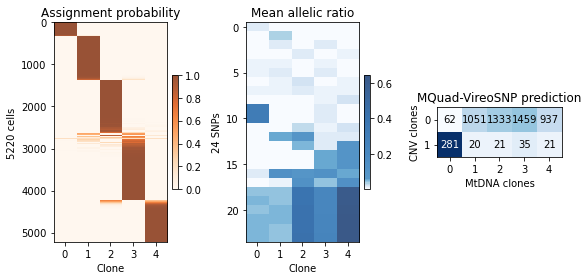

In [9]:
#assignment prob heatmap
def plot_figure_4b_confmatrix(ID_prob, ax):
    clone_id = np.argmax(ID_prob, axis=1)
    mapping = pd.read_csv('/storage/yhhuang/research/mito/mkn45/CNV-analysis-MKN45/mixtureVB-VireoSNP-mkn45/cluster_results_chr24_clusters2&3_mkn45-fulldepth_VB.csv')
    real_lab = mapping.sub24_2_r1

    confusion = confusionMatrix(real_lab, clone_id)
    res = plot_confusionMatrix(confusion, ax)
    plt.title('MQuad-VireoSNP prediction')
    plt.ylabel('CNV clones')
    plt.xlabel('MtDNA clones')
    plt.xticks(range(5), confusion.columns)
    plt.yticks(range(len(confusion)), confusion.index)
    

fig = plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

plt.subplot(1,3,2)
top = cm.get_cmap('Blues', 200)
newcolors = np.vstack((top(np.linspace(0, 0.7, 10)),
                       top(np.linspace(0.7, 1, 90))))
newcmp = ListedColormap(newcolors, name='segBlues')
AF_SNPs = mquad_modelCA.beta_mu
#rearrange clones to match fig 3b
#AF_SNPs_sorted = np.array([[i[1], i[2], i[0]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs, cmap=newcmp, alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(mquad_modelCA.n_var))
plt.xticks(range(mquad_modelCA.n_donor))

#mquad confusion matrix
ax = plt.subplot(1,3,3)
plot_figure_4b_confmatrix(mquad_modelCA.ID_prob, ax)

plt.tight_layout()

## Plot AF heatmap (Fig. 4c)
Here we plot the AF heatmap to visualize their differences between clones. First we use scipy to perform hclust (since sns.clustermap is slow with large datasets), then use the clustering result to reorder the variants in plt.imshow(). Lastly we slap the tree onto the y-axis.

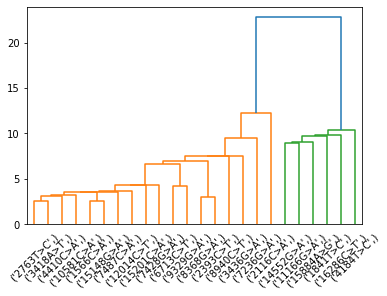

In [10]:
variants = pd.read_table('data/mquad/passed_variant_names.txt', header=None)
AF_df = pd.DataFrame(mquad_AD/mquad_DP, index=variants).fillna(0)

## perform hclust on rows instead of using snsclustermap cuz its slow af

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

linked = linkage(AF_df, 'single')
plt.subplot(1,1,1)
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            labels=AF_df.index,
            show_leaf_counts=True)
plt.show()

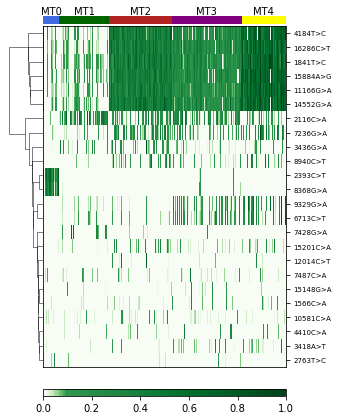

In [11]:
## AF matrix
top = cm.get_cmap('Greens', 200)

newcolors = np.vstack((top(np.linspace(0, 0.7, 10)),
                       top(np.linspace(0.7, 1, 90))))
newcmp = ListedColormap(newcolors, name='segGreens')

def plot_figure_4c_heatmap(ID_prob, ax):
    clone_id = np.argmax(ID_prob, axis=1)
    row_idx = leaves_list(linked)
    res = ax.imshow(AF_df.iloc[row_idx, np.argsort(clone_id)], cmap=newcmp, aspect='auto', interpolation='none')
    ax.axes.xaxis.set_visible(False)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    plt.yticks(range(len(AF_df)), variants.iloc[row_idx][0], fontsize=7)
    divider = make_axes_locatable(ax)
    left_ax = divider.append_axes("left", size=0.5, pad=0)
    top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)

    #ax_t = fig.add_axes([0.026,0.07,0.07,0.55], frame_on=False)
    with plt.rc_context({'lines.linewidth': 0.5}):
        d = dendrogram(linked, ax=left_ax, orientation='left', no_labels=True, color_threshold=0, link_color_func=lambda x: 'k')
    left_ax.invert_yaxis()
    left_ax.axis('off')

    #top_ax = fig.add_axes([0.095, 0.65, 0.38, 0.03], frame_on=False)
    #dont change label num
    LEFT = 0
    iicolor = 0
    c_names = ['MT0', 'MT1', 'MT2', 'MT3', 'MT4']
    label_num=np.bincount(clone_id)
    clone_pal = ['royalblue', 'darkgreen', 'firebrick', 'purple', 'yellow']
    for num in label_num:
            top_ax.barh(0,num+1,left=LEFT,color=clone_pal[iicolor])
            top_ax.text(x=LEFT + num/2, y=0.8, s=c_names[iicolor], va='center', ha='center')
            top_ax.set_xlim(0,5220)
            top_ax.axis('off')
            LEFT += num
            iicolor += 1

    bottom_ax = divider.append_axes("bottom", size=0.1, pad = 0.3)
    plt.colorbar(res, cax = bottom_ax, orientation="horizontal", shrink=0.5)


fig = plt.figure(figsize=(5,7))
ax=plt.subplot(111)
plot_figure_4c_heatmap(mquad_modelCA.ID_prob, ax)

## Evalulate performance with data downsampling (Fig. 4e)
We also evaluated the effect of n_reads on MQuad's performance. We assessed a few metrics, including number of informative variants recovered, number of assignable cells, and clone assignment concordance using the full depth data as a silver standard. Note that this step takes the longest (~1hr) as we recursively assign cells in each downsampled dataset.

In [12]:
downsample_paths = [
    'data/compare/cellsnp_half_depth/',
    'data/compare/cellsnp_third_depth/',
    'data/compare/cellsnp_quarter_depth/',
    'data/compare/cellsnp_sixth_depth/'
]

silver_standard = pd.read_csv('data/mquad/BIC_params.csv')
silver_standard_variants = silver_standard.variant_name[(silver_standard.PASS_KP == True) & (silver_standard.PASS_MINCELLS == True)]

n_var, assignable, clonal_assignment_concordance = [], [], []

from utils import *
import scipy

clone_id = np.argmax(mquad_modelCA.ID_prob, axis=1)

for p in downsample_paths:
    df = pd.read_csv(p + 'mquad/BIC_params.csv')
    AD, DP, AF = load_vcf_data(p + 'cellSNP.cells.vcf.gz')
    detected = df.variant_name[(df.PASS_KP == True) & (df.PASS_MINCELLS == True)]
    #find n_variants matching with silver_standard
    prop_match = len(set(detected) & set(silver_standard_variants))/len(set(silver_standard_variants))
    n_var.append(prop_match)
    print("Prop of informative variants recovered: ", prop_match)
    mquad_AD = scipy.sparse.csr_matrix(AD.loc[detected,:].values)
    mquad_DP = scipy.sparse.csr_matrix(DP.loc[detected,:].values)
    np.random.seed(42)
    _model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=5)
    _model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

    assignable.append(np.sum(np.max(_model.ID_prob, axis=1) > 0.8)/5220)
    
    downsample_clone_id = np.argmax(_model.ID_prob, axis=1)
    c = confusionMatrix(clone_id, downsample_clone_id)
    acc = c.max(axis=1)/c.sum(axis=1)
    clonal_assignment_concordance.append(acc)


## insert the first datapoint manually
n_var.insert(0,1)
assignable.insert(0, a)
conc = list(np.mean(clonal_assignment_concordance, axis=1))
conc.insert(0,1)

loading data from data/compare/cellsnp_half_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.625






























Precision = 0.887000072872816
Recall = 0.8963278236866236
loading data from data/compare/cellsnp_third_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.625




























Precision = 0.8623782444166558
Recall = 0.8640780316299648
loading data from data/compare/cellsnp_quarter_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.6666666666666666












































































Precision = 0.8180782849901898
Recall = 0.8133121083220807
loading data from data/compare/cellsnp_sixth_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.5833333333333334





































Precision = 0.7785590291457273
Recall = 0.7805982045729798


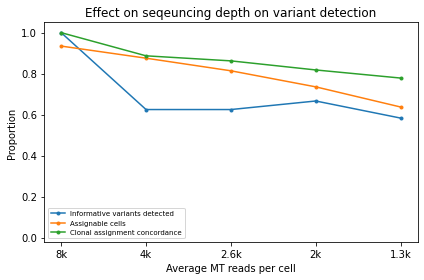

In [13]:
plt.plot(['8k', '4k', '2.6k','2k', '1.3k'],n_var, '-o', label="Informative variants detected", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k','1.3k'],assignable, '-o', label="Assignable cells", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k', '1.3k'],conc, '-o', label="Clonal assignment concordance", markersize=3)
plt.ylim([-0.02, 1.05])
plt.legend(loc = 'lower left', fontsize=7)
plt.ylabel('Proportion')
plt.xlabel('Average MT reads per cell')
plt.title('Effect on seqeuncing depth on variant detection')
#ax5.spines['right'].set_visible(False)
#ax5.spines['top'].set_visible(False)
plt.tight_layout()

In [14]:
n_var, assignable

([1, 0.625, 0.625, 0.6666666666666666, 0.5833333333333334],
 [0.9344827586206896,
  0.8754789272030651,
  0.813984674329502,
  0.735632183908046,
  0.6373563218390804])

Precision = 0.522354005625381
Recall = 0.9479421070893247


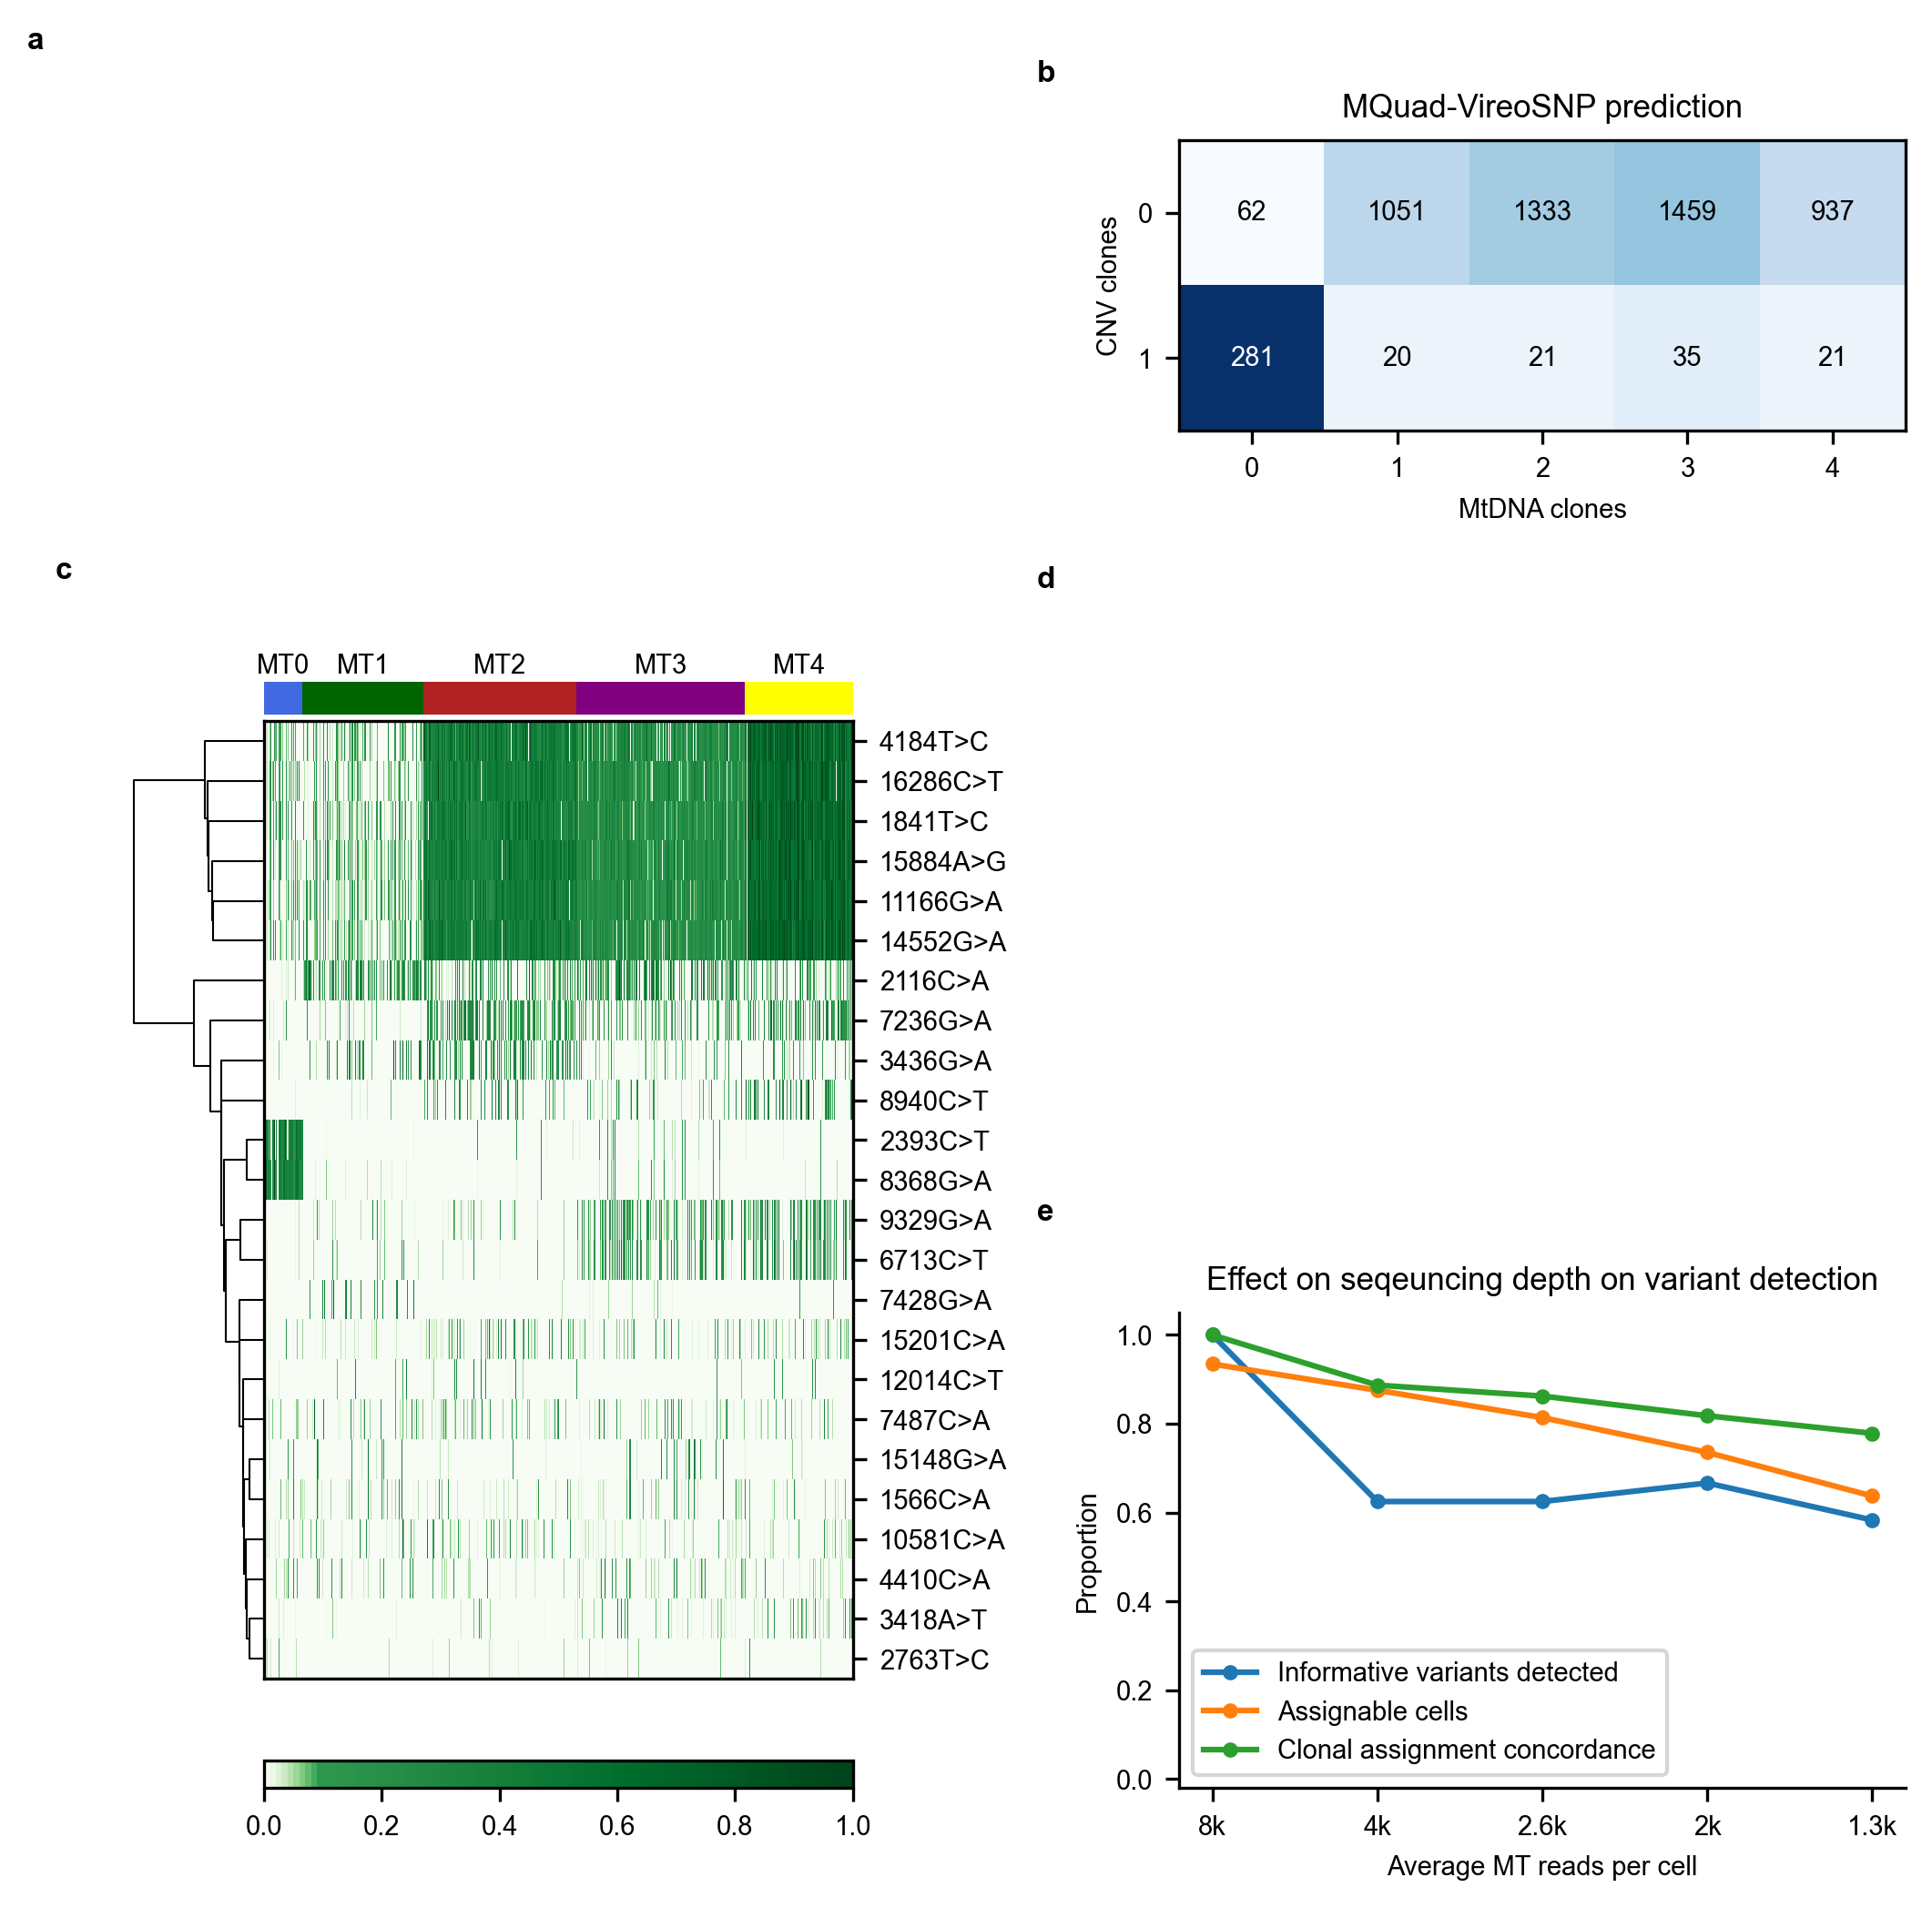

In [15]:
##put everything together

plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 7}
plt.rc('font', **font)
cm = 1/2.54
fig = plt.figure(figsize=(18*cm,7), dpi=300)

ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=3)
ax1.text(-0.35*cm, 2.5*cm, 'a', transform = ax1.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
ax1.axis('off')

ax2 = plt.subplot2grid((3, 6), (0, 3), colspan=3)
ax2.text(-0.5*cm, 3*cm, 'b', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_4b_confmatrix(mquad_modelCA.ID_prob, ax2)


ax3 = plt.subplot2grid((3, 6), (1, 0), colspan=3, rowspan=2)
ax3.text(-0.9*cm, 2.9*cm, 'c', transform = ax3.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_4c_heatmap(mquad_modelCA.ID_prob, ax3)

ax4 = plt.subplot2grid((3, 6), (1, 3), colspan=3)
ax4.text(-0.5*cm, 3*cm, 'd', transform = ax4.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
ax4.axis('off')


ax5 = plt.subplot2grid((3, 6), (2, 3), colspan=3)
ax5.text(-0.5*cm, 3*cm, 'e', transform = ax5.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')

plt.plot(['8k', '4k', '2.6k','2k', '1.3k'],n_var, '-o', label="Informative variants detected", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k','1.3k'],assignable, '-o', label="Assignable cells", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k', '1.3k'],conc, '-o', label="Clonal assignment concordance", markersize=3)
plt.ylim([-0.02, 1.05])
plt.legend(loc = 'lower left', fontsize=7)
plt.ylabel('Proportion')
plt.xlabel('Average MT reads per cell')
plt.title('Effect on seqeuncing depth on variant detection')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig('figures/figure4_tmp.svg')

## Supplementary stuff, clean up later

In [16]:
sorted_df = AF_df.iloc[row_idx, np.argsort(clone_id)].T.reset_index(drop=True).T

i = 0
dict = {}
LEFT=0
for num in label_num:
    print("i, num, left = ", i, num, LEFT)
    dict['MT'+str(i)] = sorted_df.loc[:,LEFT:LEFT+num].mean(axis=1)
    print(dict['MT'+str(i)].shape)
    LEFT += num
    i += 1

grouped = pd.DataFrame.from_dict(dict)
genotype = grouped.apply(lambda x: pd.cut(x, bins=[0, 0.01, 0.9, 1, 5], labels=['0', '1', '2', '3'], include_lowest=True))

genotype.to_csv('genotype_matrix.csv', sep= ' ', header=False, index=False)

NameError: name 'row_idx' is not defined